In [1]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import pandas as pd
import json
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of column content
pd.set_option('display.max_rows', None)  # Show all rows

In this notebook we do the same pre-processing for the listings in Shanghai and Madrid, at the end we compare both sets.

In [2]:
#Read the listings from csv files
listings_singapore=pd.read_csv('listings_singapore.csv.gz')
listings_madrid=pd.read_csv('listings_madrid.csv.gz')
# Adding 'city' column to each dataframe
listings_singapore['city']='Singapore'
listings_madrid['city']='Madrid'




In [3]:
listings_combined=pd.concat([listings_singapore,listings_madrid],axis=0)

In [4]:
listings_combined.shape

(30520, 76)

Check for duplicates

In [5]:
#Show duplicates
listings_combined.duplicated().sum()

np.int64(0)

Originally we have a total amount of 30520 listings, in the next section we are going to check which columns contain missing values.

In [6]:
missing_values = listings_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
print(missing_values)

description                     1295
neighborhood_overview          15652
picture_url                        1
host_name                          3
host_since                         3
host_location                   9497
host_about                     14969
host_response_time              6139
host_response_rate              6139
host_acceptance_rate            5159
host_is_superhost               1009
host_thumbnail_url                 3
host_picture_url                   3
host_neighbourhood             17776
host_listings_count                3
host_total_listings_count          3
host_verifications                 3
host_has_profile_pic               3
host_identity_verified             3
neighbourhood                  15652
bathrooms                       6720
bathrooms_text                    55
bedrooms                        2800
beds                            6779
price                           6693
calendar_updated               30520
has_availability                1820
f

In [7]:
#show the fields where first_review is missing, but price is not missing
listings_without_reviews= listings_combined[(listings_combined['first_review'].isnull()) & (listings_combined['price'].notnull())]


In [8]:
listings_combined_basis = listings_combined.dropna(subset=['id', 'price','first_review'])

In [9]:
listings_combined_basis.shape

(18919, 76)

After deleting the rows which does not contain price or first review, we keep 18.919 listings.

In [10]:
missing_values2 = listings_combined_basis.isnull().sum()
missing_values2 = missing_values2[missing_values2 > 0]  # Filter only columns with missing values
print(missing_values2)

description                      582
neighborhood_overview           8480
host_location                   5596
host_about                      8915
host_response_time              1075
host_response_rate              1075
host_acceptance_rate             553
host_is_superhost                822
host_neighbourhood             11514
neighbourhood                   8480
bathrooms                         16
bathrooms_text                    30
bedrooms                           9
beds                              36
calendar_updated               18919
has_availability                   8
review_scores_accuracy             2
review_scores_cleanliness          3
review_scores_checkin              3
review_scores_communication        2
review_scores_location             2
review_scores_value                2
license                        16001
dtype: int64


In [11]:
listings_combined_basis.shape

(18919, 76)

In [12]:
listings_combined_basis.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

In [12]:
# Calculate distance to the city center for each listing
def calculate_distance(row):
    return geodesic((row['latitude'], row['longitude']), (row['mean_latitude'], row['mean_longitude'])).km

In [13]:
#We change common amenites below, with the amenities derived from the general preprocessing, otherwise the test set will not have the same columns

In [14]:
from sklearn.preprocessing import OrdinalEncoder

In [15]:
# Assume listings_combined2 is the DataFrame
# Define relevant columns to keep
columns_to_keep = [
    'id', 'last_scraped', 'neighborhood_overview', 
    'host_since', 'host_location', 'host_about', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'host_listings_count', 'host_has_profile_pic', 
    'host_identity_verified', 'latitude', 'longitude', 
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 
    'instant_bookable', 'city'
]

# Filter the DataFrame to keep only relevant columns
listings_combined3 = listings_combined_basis[columns_to_keep]

# Convert date columns to datetime
listings_combined3['last_scraped'] = pd.to_datetime(listings_combined3['last_scraped'])
listings_combined3['host_since'] = pd.to_datetime(listings_combined3['host_since'])
listings_combined3['host_duration'] = (listings_combined3['last_scraped'] - listings_combined3['host_since']).dt.days

# Convert binary features with a lot of missing values to numerical, where 1 represents a value and 0 represents a missing value
binary_columns = ['neighborhood_overview', 'host_location', 'host_about']
for col in binary_columns:
    listings_combined3[col] = listings_combined3[col].notna().astype(int)

#Convert other binary features to numerical, where missing values are filled with 0
other_binaries= ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable'] 
for col in other_binaries:
    listings_combined3[col] = listings_combined3[col].map({'f': 0, 't': 1}).fillna(0).astype(int)

# Convert amenities from JSON format and apply one-hot encoding for common amenities
listings_combined3['amenities'] = listings_combined3['amenities'].apply(lambda x: json.loads(x))

# Get the most common amenities (between  F10% and 90% occurrence)
common_amenities = ['Body soap',
       'Coffee maker', 'Carbon monoxide alarm', 'Smoke alarm',
       'Extra pillows and blankets', 'Luggage dropoff allowed', 'Hair dryer',
       'Elevator', 'Wifi', 'Cleaning available during stay',
       'Air conditioning', 'Hangers', 'Essentials', 'Heating', 'TV',
       'First aid kit', 'Shampoo', 'Fire extinguisher', 'Bed linens',
       'Dishes and silverware', 'Toaster', 'Shower gel', 'Coffee',
       'Portable fans', 'Dedicated workspace', 'Cooking basics', 'Hot water',
       'Iron', 'Cleaning products', 'Clothing storage: closet', 'Mini fridge',
       'Refrigerator', 'Crib', 'Wine glasses', 'Bathtub',
       'Lock on bedroom door', 'Host greets you', 'Conditioner', 'Dishwasher',
       'Hot water kettle', 'Dining table', 'Long term stays allowed',
       'Freezer', 'Laundromat nearby', 'Room-darkening shades',
       'Private entrance', 'Central heating', 'Private patio or balcony',
       'Outdoor furniture', 'Microwave', 'Single level home',
       'Outdoor dining area', 'Free washer – In unit', 'Blender',
       'Ethernet connection', 'Free dryer – In unit', 'Baking sheet',
       'Lockbox', 'Self check-in', 'Washer', 'Free parking on premises',
       'Dryer', 'Exterior security cameras on property', 'Pets allowed',
       'Drying rack for clothing', 'Oven', 'Books and reading material',
       'Free street parking', 'Patio or balcony', 'Stove', 'Clothing storage',
       'Bidet']

# Create binary columns for each common amenity
for amenity in common_amenities:
    listings_combined3[amenity] = listings_combined3['amenities'].apply(lambda x: 1 if amenity in x else 0)

# Drop the original amenities column
listings_combined3.drop(columns=['amenities'], inplace=True)

# Modify property_type to keep only those with at least 1% of the listings, replace others with 'Other'
property_type_counts = listings_combined3['property_type'].value_counts(normalize=True)
valid_property_types = property_type_counts[property_type_counts >= 0.01].index
listings_combined3['property_type'] = listings_combined3['property_type'].apply(lambda x: x if x in valid_property_types else 'Other')

# Convert percentages to numerical values and fill NA with mean
listings_combined3['host_response_rate'] = listings_combined3['host_response_rate'].str.replace('%', '').astype(float) / 100
listings_combined3['host_acceptance_rate'] = listings_combined3['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
listings_combined3['host_response_rate'].fillna(listings_combined3['host_response_rate'].mean(), inplace=True)
listings_combined3['host_acceptance_rate'].fillna(listings_combined3['host_acceptance_rate'].mean(), inplace=True)

# Calculate the mean latitude and longitude per city to determine the central location
mean_coordinates = listings_combined3.groupby('city')[['latitude', 'longitude']].mean().rename(columns={'latitude': 'mean_latitude', 'longitude': 'mean_longitude'})
listings_combined3 = listings_combined3.merge(mean_coordinates, on='city')

# Calculate distance to the city center for each listing
listings_combined3['distance_to_center'] = listings_combined3.apply(calculate_distance, axis=1)

# Drop mean latitude and longitude columns
listings_combined3.drop(columns=['mean_latitude', 'mean_longitude'], inplace=True)

# Ordinal encode categorical features
# Create a column indicating missing values in 'host_response_time'
listings_combined3['host_response_time_missing'] = listings_combined3['host_response_time'].isnull().astype(int)

# Fill missing values in 'host_response_time' if necessary, before label encoding
listings_combined3['host_response_time'].fillna('Missing', inplace=True)

# Apply Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
categorical_columns = ['host_response_time', 'property_type', 'room_type', 'city']
listings_combined3[categorical_columns] = listings_combined3[categorical_columns].astype(str)
listings_combined3[categorical_columns] = ordinal_encoder.fit_transform(listings_combined3[categorical_columns])

#Delete host_response_time_missing column, delete host_since and last_scraped columns
listings_combined3.drop(columns=['host_response_time_missing'], inplace=True)
listings_combined3.drop(columns=['host_since', 'last_scraped'], inplace=True)

# Convert price to numerical
listings_combined3['price'] = listings_combined3['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing values with the median for bathrooms, bedrooms.
median_fill_columns = ['bathrooms', 'bedrooms']
for column in median_fill_columns:
    listings_combined3[column].fillna(listings_combined3[column].median(), inplace=True)

# Display the cleaned DataFrame
print(listings_combined3.head())


<>:105: SyntaxWarning: invalid escape sequence '\$'
<>:105: SyntaxWarning: invalid escape sequence '\$'
C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1175942365.py:105: SyntaxWarning: invalid escape sequence '\$'
  listings_combined3['price'] = listings_combined3['price'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1175942365.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_combined3['last_scraped'] = pd.to_datetime(listings_combined3['last_scraped'])
C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1175942365.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

       id  neighborhood_overview  host_location  host_about  \
0   71896                      0              1           1   
1   71903                      1              1           1   
2  275343                      0              1           1   
3  275344                      1              1           1   
4  294281                      0              1           1   

   host_response_time  host_response_rate  host_acceptance_rate  \
0                 4.0            1.000000              0.887823   
1                 4.0            1.000000              0.887823   
2                 4.0            1.000000              0.990000   
3                 4.0            1.000000              0.990000   
4                 0.0            0.948385              0.887823   

   host_is_superhost  host_listings_count  host_has_profile_pic  \
0                  0                  6.0                     1   
1                  0                  6.0                     1   
2                

C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1175942365.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_combined3['host_response_time'].fillna('Missing', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1175942365.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

We check which city belongs to which number, because this is needed later in the research

In [16]:
# Fit the label encoder to the 'city' column in the original dataset
label_encoder = LabelEncoder()
label_encoder.fit(listings_combined_basis['city'])

# Display the mapping
city_mapping = {encoded_value: city for encoded_value, city in enumerate(label_encoder.classes_)}
for encoded_value, city in city_mapping.items():
    print(f"{encoded_value}: {city}")


0: Madrid
1: Singapore


We use the code below, to check all variables for outliers. We checked all numerical variables, for the binaries we already assume there are no outliers, because of the way these binaries are designed. We only change the outliers if we believe they are unrealistic, for only one we find is the one below which has 50 bedrooms and bathrooms, while the accommodation only accomodates 4 persons.

In [17]:
listings_combined3['bathrooms'].describe()

count    18919.000000
mean         1.307997
std          0.686638
min          0.000000
25%          1.000000
50%          1.000000
75%          1.500000
max         10.000000
Name: bathrooms, dtype: float64

In [18]:
listings_combined3['distance_to_center'].describe()

count    18919.000000
mean         2.755940
std          2.321666
min          0.039596
25%          1.192402
50%          1.843769
75%          3.797896
max         18.391372
Name: distance_to_center, dtype: float64

In [19]:
#Check the observations where bathrooms is above 30
bathrooms_check=listings_combined3[listings_combined3['bathrooms'] > 30]
#impute the number of bathrooms and bedrooms from the listings_combined2 by their respecitve means
listings_combined3['bathrooms'] = listings_combined3['bathrooms'].replace(50, listings_combined3['bathrooms'].mean())
listings_combined3['bedrooms'] = listings_combined3['bedrooms'].replace(50, listings_combined3['bedrooms'].mean())


Delete the number of beds, because it correlates to much with 'Accommodates'

In [20]:
listings_combined3.drop(columns=['beds'], inplace=True)

In [21]:
# Eliminate data of houses with prices greater than $40000 or less than or equal to $0
listings_combined3 = listings_combined3[(listings_combined3['price'] > 0) & (listings_combined3['price'] <= 40000)]

# Impute missing values with the mean for numerical columns
for col in listings_combined3.select_dtypes(include=['float64', 'int64']).columns:
    listings_combined3[col].fillna(listings_combined3[col].mean(), inplace=True)

# Apply logarithmic transformation to the price column
listings_combined3['price'] = np.log1p(listings_combined3['price'])

listings_combined3.shape

C:\Users\PC\AppData\Local\Temp\ipykernel_14736\1127158049.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listings_combined3[col].fillna(listings_combined3[col].mean(), inplace=True)


(18919, 98)

Number of columns is the same as in the preprocessing of the 10 big cities

We do a outlier analysis, to see if this worked out

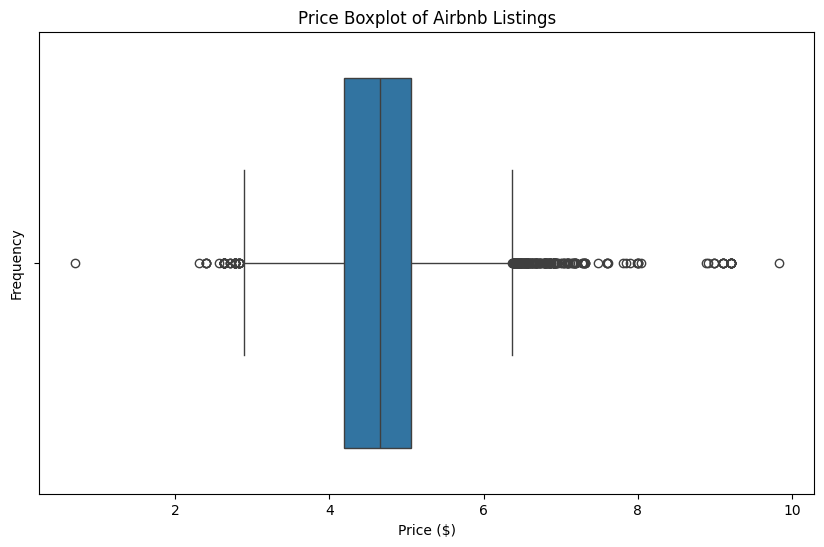

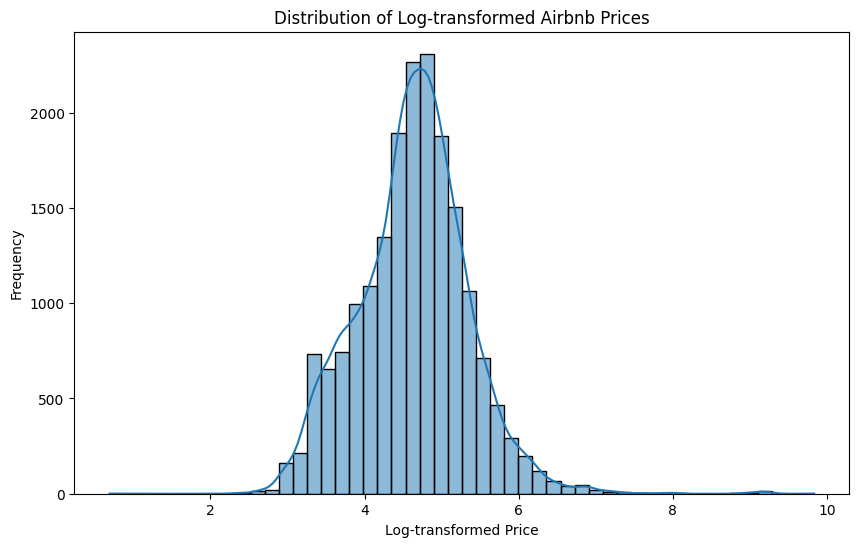

In [22]:
# Visualize price distribution using a boxplot to analyze outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=listings_combined3['price'])
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Price Boxplot of Airbnb Listings')
plt.show()
# Visualize price distribution using a histogram to analyze outliers
plt.figure(figsize=(10, 6))
sns.histplot(listings_combined3['price'], bins=50, kde=True)
plt.xlabel('Log-transformed Price')
plt.ylabel('Frequency')
plt.title('Distribution of Log-transformed Airbnb Prices')
plt.show()


If we look at the distribution, we see that there are stil outliers, we decide to adjust the distribution and only keep columns where the log-transformed price is between 2 and 8.

In [23]:
#delete columns where log price below 2 or above 8
listings_combined3 = listings_combined3[(listings_combined3['price'] > 2) & (listings_combined3['price'] < 8)]
listings_combined3.shape

(18892, 98)

In [24]:
listings_combined3.columns

Index(['id', 'neighborhood_overview', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'price',
       'minimum_nights', 'maximum_nights', 'availability_365',
       'instant_bookable', 'city', 'host_duration', 'Body soap',
       'Coffee maker', 'Carbon monoxide alarm', 'Smoke alarm',
       'Extra pillows and blankets', 'Luggage dropoff allowed', 'Hair dryer',
       'Elevator', 'Wifi', 'Cleaning available during stay',
       'Air conditioning', 'Hangers', 'Essentials', 'Heating', 'TV',
       'First aid kit', 'Shampoo', 'Fire extinguisher', 'Bed linens',
       'Dishes and silverware', 'Toaster', 'Shower gel', 'Coffee',
       'Portable fans', 'Dedicated workspace', 'Cooking basics', 'Hot water',
       'Iron', 'Cleani

As expected there is a difference in amenities that are in the common amenities

In [25]:
listings_combined3.to_csv('listings_features_label_encoded_outofsample.csv', index=False)

In [26]:
listings_combined3.shape

(18892, 98)

So the final shape of this one-hot encoded feature set is (210937,99)

We now saved a file for the listing reviews and the next step is to do the same for the review features, we first collect and select all relevant features related to reviews that are in this listing dataset and nextly we add the LDA related sentiment scores that are extracted from the reviews dataset. We do this in a separate notebook.

In [27]:
#From listings_combined_basis, we keep the ID for merging purpose
review_data = listings_combined_basis[['id', 'last_scraped','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'first_review', 'last_review', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'reviews_per_month']]

In [28]:
#Change the rows of the review data to listings_combined3 to have the same subset of listings that are preprocessed similarly on the price variable.
review_data = review_data[review_data['id'].isin(listings_combined3['id'])]


In [29]:
review_data.shape

(18892, 15)

In [30]:
#Drop review_scores_rating, 'number_of_reviews_ltm', 'number_of_reviews_l30d'
review_data.drop(columns=['review_scores_rating', 'number_of_reviews_ltm', 'reviews_per_month'], inplace=True)


In [31]:
#Show missing values
missing_values = review_data.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
print(missing_values)

review_scores_accuracy         2
review_scores_cleanliness      3
review_scores_checkin          3
review_scores_communication    2
review_scores_location         2
review_scores_value            2
dtype: int64


In [32]:
# Assuming listings_combined and review_data are already defined
review_data = review_data.reset_index(drop=True)

# Step 4: Add columns from columns to add to review_data
review_data = review_data

# Convert date columns to datetime
review_data['first_review'] = pd.to_datetime(review_data['first_review'])
review_data['last_review'] = pd.to_datetime(review_data['last_review'])
review_data['last_scraped'] = pd.to_datetime(review_data['last_scraped'])

# Create new columns for the number of days between first and last reviews
review_data['days_between_first_review'] = (review_data['last_scraped'] - review_data['first_review']).dt.days
review_data['days_since_last_review'] = (review_data['last_scraped'] - review_data['last_review']).dt.days

# Step 5: Impute missing values 
review_data['number_of_reviews']
review_data['review_scores_accuracy'].fillna(review_data['review_scores_accuracy'].median(), inplace=True)
review_data['review_scores_cleanliness'].fillna(review_data['review_scores_cleanliness'].median(), inplace=True)
review_data['review_scores_checkin'].fillna(review_data['review_scores_checkin'].median(), inplace=True)
review_data['review_scores_communication'].fillna(review_data['review_scores_communication'].median(), inplace=True)
review_data['review_scores_location'].fillna(review_data['review_scores_location'].median(), inplace=True)
review_data['review_scores_value'].fillna(review_data['review_scores_value'].median(), inplace=True)

# Drop the date columns if no longer needed
review_data.drop(columns=['first_review', 'last_review', 'last_scraped'], inplace=True)

# Print out the head of review_data to check the results
print(review_data.head())



       id  number_of_reviews  number_of_reviews_l30d  review_scores_accuracy  \
0   71896                 24                       0                    4.22   
1   71903                 46                       0                    4.39   
2  275343                 20                       0                    4.16   
3  275344                 16                       0                    4.44   
4  294281                131                       0                    4.33   

   review_scores_cleanliness  review_scores_checkin  \
0                       4.09                   4.43   
1                       4.52                   4.63   
2                       4.26                   4.47   
3                       4.06                   4.50   
4                       4.16                   4.50   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         4.43                    4.17                 4.04   
1                         4.64

C:\Users\PC\AppData\Local\Temp\ipykernel_14736\394644142.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  review_data['review_scores_accuracy'].fillna(review_data['review_scores_accuracy'].median(), inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_14736\394644142.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [33]:
review_data.shape

(18892, 11)

So the final shape of this review feature set is (210937,11)

In [34]:
#save review_data to a csv file
review_data.to_csv('listings_features_reviews_out_of_sample.csv', index=False)